In [207]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## Data Description

    Date:    The date this data pertains to.
    Open:    The opening price for the asset on the given date.
    High:    The high price for the asset on the given date.
    Low:     Low proce for theasset on the given date
    close:   closing proce for the asset on given date.
    Volume:  The number of shares traded on IEX only.

In [208]:
def ticker_details(token):
    meta_url="https://api.tiingo.com/tiingo/fundamentals/meta?token={}".format(token)
    ticker=requests.get(meta_url)
    ticker_df=ticker.json()
    return ticker_df
ticker_df=ticker_details(token='a159a3a83b1754845d7353fbec1c9f2902d4a8e1')

In [209]:
ticker_df=pd.json_normalize(ticker_df)
ticker_df=ticker_df.iloc[:,1:3]
#ticker_list=ticker_df.values.tolist()
ticker_df.iloc[:,:-1]

,ticker
0,a
1,aa
2,aaab
3,aaagy
4,aaap
...,...
18499,zyme
18500,zyne
18501,zyto
18502,zyxi


In [210]:
# getting data from tiingo webesite using API 
'''
ticker name= stock name in tiingo website
Start Date= Date from when we need historical data of a stock(format YYYY-MM-DD)
resampleFreq = This allows you to set the frequency in which you want data resampled. For example "1hour" would return the data where OHLC is calculated on an hourly schedule.

'''
print('ticker details:{ticker_names}'.format(ticker_names=ticker_df))
def data_extraction(ticker_name,startDate,resampleFreq,token):
    url="https://api.tiingo.com/iex/{}/prices?startDate={}&resampleFreq={}&columns=open,high,low,close,volume&token={}".format(ticker_name,startDate,resampleFreq,token)

    data=requests.get(url)
    dataset=data.json()
    #print(data.status_code)
    return dataset
    
json_dataset=data_extraction(ticker_name=input('Enter ticker(stock_name) name:'),startDate='2019-01-02',resampleFreq='1hour',token='a159a3a83b1754845d7353fbec1c9f2902d4a8e1')

ticker details:      ticker                                  name
0          a              Agilent Technologies Inc
1         aa                            Alcoa Corp
2       aaab                 ADMIRALTY BANCORP INC
3      aaagy     ALTANA AKTIENGESELLSCHAFT Foreign
4       aaap  Advanced Accelerator Applications SA
...      ...                                   ...
18499   zyme                      Zymeworks BC Inc
18500   zyne           Zynerba Pharmaceuticals Inc
18501   zyto                             ZYTO CORP
18502   zyxi                             Zynex Inc
18503     zz                            Sealy Corp

[18504 rows x 2 columns]
Enter ticker(stock_name) name:infy


In [211]:
stock_df=pd.json_normalize(json_dataset)
stock_df

,date,open,high,low,close,volume
0,2019-01-02T15:00:00.000Z,9.655,9.710,9.635,9.705,307167.0
1,2019-01-02T16:00:00.000Z,9.705,9.725,9.670,9.675,125119.0
2,2019-01-02T17:00:00.000Z,9.670,9.690,9.665,9.690,167504.0
3,2019-01-02T18:00:00.000Z,9.685,9.715,9.685,9.705,108728.0
4,2019-01-02T19:00:00.000Z,9.705,9.705,9.615,9.625,51810.0
...,...,...,...,...,...,...
8241,2023-07-07T16:00:00.000Z,16.105,16.165,16.105,16.165,30874.0
8242,2023-07-07T17:00:00.000Z,16.165,16.175,16.120,16.125,34120.0
8243,2023-07-07T18:00:00.000Z,16.125,16.130,16.105,16.115,25048.0
8244,2023-07-07T19:00:00.000Z,16.115,16.115,16.020,16.050,68018.0


## checking NULL values

In [212]:
NULL_check=stock_df.isnull().sum()

if (NULL_check.values>0).any():
    print("Null values present")

else:
    print("No null values")


No null values


#### Observation:  
    NO null values 

## Checking data types

In [213]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8246 non-null   object 
 1   open    8246 non-null   float64
 2   high    8246 non-null   float64
 3   low     8246 non-null   float64
 4   close   8246 non-null   float64
 5   volume  8246 non-null   float64
dtypes: float64(5), object(1)
memory usage: 386.7+ KB


In [214]:
## converting date column into datetime format

stock_df['date']=pd.to_datetime(stock_df['date'])

## Checking data from period to period

In [215]:
stock_df.head(),stock_df.tail()

(                       date   open   high    low  close    volume
 0 2019-01-02 15:00:00+00:00  9.655  9.710  9.635  9.705  307167.0
 1 2019-01-02 16:00:00+00:00  9.705  9.725  9.670  9.675  125119.0
 2 2019-01-02 17:00:00+00:00  9.670  9.690  9.665  9.690  167504.0
 3 2019-01-02 18:00:00+00:00  9.685  9.715  9.685  9.705  108728.0
 4 2019-01-02 19:00:00+00:00  9.705  9.705  9.615  9.625   51810.0,
                           date    open    high     low   close   volume
 8241 2023-07-07 16:00:00+00:00  16.105  16.165  16.105  16.165  30874.0
 8242 2023-07-07 17:00:00+00:00  16.165  16.175  16.120  16.125  34120.0
 8243 2023-07-07 18:00:00+00:00  16.125  16.130  16.105  16.115  25048.0
 8244 2023-07-07 19:00:00+00:00  16.115  16.115  16.020  16.050  68018.0
 8245 2023-07-07 20:00:00+00:00  16.115  16.115  16.020  16.050      0.0)

### Observation
    data is 
    starting--------------'2019-01-02'(yyy-mm-dd)
    till------------------'2023-07-0'

In [216]:
# using close column to predict the stock
close_stock=stock_df['close']

In [217]:
close_stock.tail()

8241    16.165
8242    16.125
8243    16.115
8244    16.050
8245    16.050
Name: close, dtype: float64

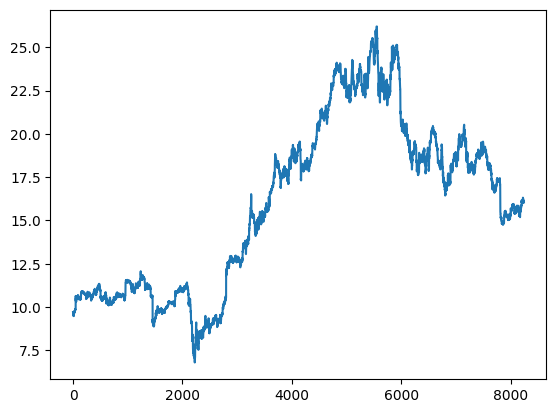

In [218]:
plt.plot(close_stock)

## Data Scaling 

        LSTM are sensitive to the scale of data. So we apply MinMax scaler

In [219]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
close_stock=scaler.fit_transform(np.array(close_stock).reshape(-1,1))

In [220]:
close_stock

array([[0.14956163],
       [0.14801444],
       [0.14878804],
       ...,
       [0.4801444 ],
       [0.47679216],
       [0.47679216]])

## Train Test split

    >since the problem here is time series we dont use cross validation or random seed for train test split
    >the data is depend on previous data for any time series
        ex:- Day1  Day2  Day3
              120  130    145
              
              here day2 value depend on day1 stock close value

In [221]:
#Splitting train and test data

training_size=int(len(close_stock)*0.65) #65% train data
test_size=len(close_stock)-training_size  # 35% test size

In [222]:
training_size,test_size

(5359, 2887)

In [223]:
# we prepare train and test data by using above training_size and test_size

#since trainnig size is 5339 train data will be till 0 to 5350
train_data,test_data=close_stock[0:training_size,:],close_stock[training_size:len(close_stock),:1]

In [224]:
len(train_data),len(test_data)

(5359, 2887)

## Data Preprocessing

In [225]:
# conveting an array of values into dataset matrix

def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [226]:
#reshaping 
time_step=150
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [227]:
print(X_train.shape)
print(X_test.shape)

(5208, 150)
(2736, 150)


# Creating Stacked LSTM model

 we should remember that before implementing the lstm model we should reshape our X_train and X_test to 3 dimensionals

In [228]:
#reshaping input to be[samples,time steps,features]
##X_train.shape[0],X_train.shape[1],1--(5253, 100, 1) 1 is nothing but time step

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [229]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [230]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))# first layer we pass "X_train.shape[1],1"
model.add(LSTM(50,return_sequences=True))# second layer
model.add(LSTM(50))#third layer
model.add(Dense(1))#output layer

model.compile(loss="mean_squared_error",optimizer='adam')

In [231]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 150, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [232]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=64,verbose=1)

Epoch 1/2
82/82 [==============================] - 53s 571ms/step - loss: 0.0109 - val_loss: 4.9486e-04
Epoch 2/2
82/82 [==============================] - 43s 528ms/step - loss: 2.2216e-04 - val_loss: 5.4178e-04


In [233]:
# predicitions for test and train data

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

86/86 [==============================] - 9s 100ms/step


In [234]:
# Transforming back to original form for calculating RMSE
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [235]:
# calculating RMSE performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

14.682949254310957

In [236]:
##test data RMSE

math.sqrt(mean_squared_error(y_test,test_predict))

18.751178086807094

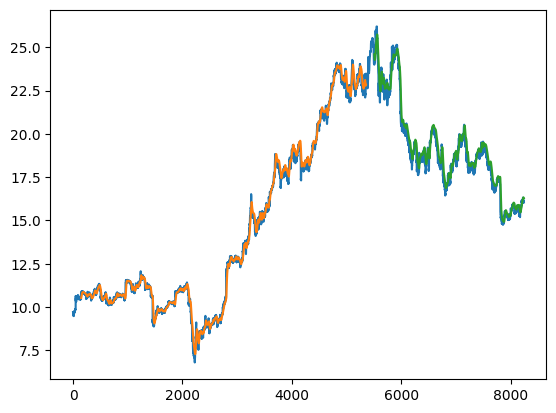

In [237]:
## plotting graph for both test and train data predictions
'''
orange color= train prediction
bule color = full data
green color=test prediction
'''
# shifting train predictions for plotting
look_back=150
trainpredictplot=np.empty_like(close_stock)
trainpredictplot[:,:]=np.nan
trainpredictplot[look_back:len(train_predict)+look_back,:]=train_predict

#shifting test predictions for plotting

testpredictplot=np.empty_like(close_stock)
testpredictplot[:,:]=np.nan
testpredictplot[len(train_predict)+(look_back*2)+1:len(close_stock)-1, :]=test_predict

#plot baseline and predicitons
plt.plot(scaler.inverse_transform(close_stock))
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.show()

In [238]:
len(test_data)

2887

In [239]:
previous_days=150
restofdays_in_dataset=len(test_data)-previous_days
x_input=test_data[restofdays_in_dataset:].reshape(1,-1)

x_input.shape


(1, 150)

In [240]:
#converting into list 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.446106240330067,
 0.446106240330067,
 0.446106240330067,
 0.447137699845281,
 0.4455905105724601,
 0.44765342960288806,
 0.448169159360495,
 0.448169159360495,
 0.44662197008767407,
 0.44662197008767407,
 0.46106240330067044,
 0.46209386281588455,
 0.46209386281588455,
 0.4615781330582775,
 0.4646725116039195,
 0.46441464672511606,
 0.46441464672511606,
 0.46518824136152653,
 0.4595152140278494,
 0.4615781330582775,
 0.46312532233109854,
 0.46544610624033006,
 0.4669932955131511,
 0.4669932955131511,
 0.4636410520887055,
 0.46621970087674064,
 0.46312532233109854,
 0.4574522949974214,
 0.4530685920577617,
 0.44971634863331617,
 0.44971634863331617,
 0.4499742135121196,
 0.45358432181536873,
 0.45281072717895826,
 0.4546157813305827,
 0.45410005157297567,
 0.4551315110881898,
 0.4551315110881898,
 0.45693656523981424,
 0.45796802475502835,
 0.46312532233109854,
 0.46209386281588455,
 0.4626095925734915,
 0.46621970087674064,
 0.46621970087674064,
 0.46621970087674064,
 0.466219700876

In [241]:
from numpy import array

lst_output=[]
n_steps=150
i=0
while (i<100):
    #if pevious input is greater than 100 . the whole process will happen util we finish 100 days
    if(len(temp_input)>150):
        #we shift the position
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input) )
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print("{} day output".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        #passing 100 values to model 
        yhat=model.predict(x_input,verbose=0)
        #adding yhat value to previous values i.e temp_input.once we add value it will have 151 value then we shift from one postion and take from next(if condition)
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        #adding yhat value from predict to final output
        lst_output.extend(yhat.tolist())
        i=i+1
            

151
1 day input [0.44610624 0.44610624 0.4471377  0.44559051 0.44765343 0.44816916
 0.44816916 0.44662197 0.44662197 0.4610624  0.46209386 0.46209386
 0.46157813 0.46467251 0.46441465 0.46441465 0.46518824 0.45951521
 0.46157813 0.46312532 0.46544611 0.4669933  0.4669933  0.46364105
 0.4662197  0.46312532 0.45745229 0.45306859 0.44971635 0.44971635
 0.44997421 0.45358432 0.45281073 0.45461578 0.45410005 0.45513151
 0.45513151 0.45693657 0.45796802 0.46312532 0.46209386 0.46260959
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.45435792 0.45538938 0.45899948
 0.45771016 0.45745229 0.45564724 0.45564724 0.43630737 0.43785456
 0.44146467 0.44404332 0.44352759 0.44249613 0.44249613 0.43630737
 0.44249613 0.44584838 0.44662197 0.44816916 0.44662197 0.44662197
 0.43527592 0.43424446 0.43424446 0.43295513 0.4324394  0.43295513
 0.43295513 0.44662197 0.44894275 0.44765343 0.44765343 0.44765343
 0.44791129 0.44791129 0.45126354 0.452295   0.

5 day output
6 day input [0.44816916 0.44816916 0.44662197 0.44662197 0.4610624  0.46209386
 0.46209386 0.46157813 0.46467251 0.46441465 0.46441465 0.46518824
 0.45951521 0.46157813 0.46312532 0.46544611 0.4669933  0.4669933
 0.46364105 0.4662197  0.46312532 0.45745229 0.45306859 0.44971635
 0.44971635 0.44997421 0.45358432 0.45281073 0.45461578 0.45410005
 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532 0.46209386
 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.45435792 0.45538938
 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724 0.43630737
 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613 0.44249613
 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916 0.44662197
 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513 0.4324394
 0.43295513 0.43295513 0.44662197 0.44894275 0.44765343 0.44765343
 0.44765343 0.44791129 0.44791129 0.45126354 0.452295   0.45074781
 0.4515214  0.45306859 0.45487365 0.4548

11 day output
12 day input [0.46209386 0.46157813 0.46467251 0.46441465 0.46441465 0.46518824
 0.45951521 0.46157813 0.46312532 0.46544611 0.4669933  0.4669933
 0.46364105 0.4662197  0.46312532 0.45745229 0.45306859 0.44971635
 0.44971635 0.44997421 0.45358432 0.45281073 0.45461578 0.45410005
 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532 0.46209386
 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.45435792 0.45538938
 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724 0.43630737
 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613 0.44249613
 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916 0.44662197
 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513 0.4324394
 0.43295513 0.43295513 0.44662197 0.44894275 0.44765343 0.44765343
 0.44765343 0.44791129 0.44791129 0.45126354 0.452295   0.45074781
 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308 0.46003094
 0.45951521 0.45951521 0.46054667 0.46

16 day output
17 day input [0.46518824 0.45951521 0.46157813 0.46312532 0.46544611 0.4669933
 0.4669933  0.46364105 0.4662197  0.46312532 0.45745229 0.45306859
 0.44971635 0.44971635 0.44997421 0.45358432 0.45281073 0.45461578
 0.45410005 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532
 0.46209386 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.46621

22 day output
23 day input [0.4669933  0.46364105 0.4662197  0.46312532 0.45745229 0.45306859
 0.44971635 0.44971635 0.44997421 0.45358432 0.45281073 0.45461578
 0.45410005 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532
 0.46209386 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.4806

28 day output
29 day input [0.44971635 0.44971635 0.44997421 0.45358432 0.45281073 0.45461578
 0.45410005 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532
 0.46209386 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.4775

34 day output
35 day input [0.45410005 0.45513151 0.45513151 0.45693657 0.45796802 0.46312532
 0.46209386 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.4814

40 day output
41 day input [0.46209386 0.46260959 0.4662197  0.4662197  0.4662197  0.4662197
 0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.4814

46 day output
47 day input [0.4662197  0.4662197  0.4662197  0.4662197  0.4662197  0.45435792
 0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.487

52 day output
53 day input [0.45538938 0.45899948 0.45771016 0.45745229 0.45564724 0.45564724
 0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.477

58 day output
59 day input [0.43630737 0.43785456 0.44146467 0.44404332 0.44352759 0.44249613
 0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.480

64 day output
65 day input [0.44249613 0.43630737 0.44249613 0.44584838 0.44662197 0.44816916
 0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444  0.47679216
 0.47679216 0.4886753  0.48847675 0.488

70 day output
71 day input [0.44662197 0.44662197 0.43527592 0.43424446 0.43424446 0.43295513
 0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444  0.47679216
 0.47679216 0.4886753  0.48847675 0.48839343 0.48843941 0.48861244
 0.4889006  0.48928684 0.48975265 0.490

76 day output
77 day input [0.4324394  0.43295513 0.43295513 0.44662197 0.44894275 0.44765343
 0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444  0.47679216
 0.47679216 0.4886753  0.48847675 0.48839343 0.48843941 0.48861244
 0.4889006  0.48928684 0.48975265 0.49028006 0.49085355 0.49146
 0.49208903 0.4927327  0.49338558 0.494043

82 day output
83 day input [0.44765343 0.44765343 0.44791129 0.44791129 0.45126354 0.452295
 0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444  0.47679216
 0.47679216 0.4886753  0.48847675 0.48839343 0.48843941 0.48861244
 0.4889006  0.48928684 0.48975265 0.49028006 0.49085355 0.49146
 0.49208903 0.4927327  0.49338558 0.49404356 0.49470443 0.49536648
 0.49602935 0.49669233 0.49735579 0.498019

88 day output
89 day input [0.45074781 0.4515214  0.45306859 0.45487365 0.45487365 0.45977308
 0.46003094 0.45951521 0.45951521 0.46054667 0.461836   0.461836
 0.46828262 0.46879835 0.46802476 0.4662197  0.46725116 0.46931408
 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576 0.47859722
 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181 0.49020113
 0.490459   0.4896854  0.48684889 0.48762249 0.48762249 0.47447138
 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935 0.47833935
 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444  0.47679216
 0.47679216 0.4886753  0.48847675 0.48839343 0.48843941 0.48861244
 0.4889006  0.48928684 0.48975265 0.49028006 0.49085355 0.49146
 0.49208903 0.4927327  0.49338558 0.49404356 0.49470443 0.49536648
 0.49602935 0.49669233 0.49735579 0.49801984 0.49868461 0.49935064
 0.50001806 0.500687   0.50135779 0.5020

93 day output
94 day input [0.45977308 0.46003094 0.45951521 0.45951521 0.46054667 0.461836
 0.461836   0.46828262 0.46879835 0.46802476 0.4662197  0.46725116
 0.46931408 0.46931408 0.48272305 0.47550284 0.48066013 0.47756576
 0.47859722 0.47756576 0.47756576 0.48117586 0.47756576 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48891181
 0.49020113 0.490459   0.4896854  0.48684889 0.48762249 0.48762249
 0.47447138 0.47782362 0.47782362 0.47859722 0.47730789 0.47833935
 0.47833935 0.47962867 0.47988654 0.48272305 0.48066013 0.4801444
 0.47679216 0.47679216 0.4886753  0.48847675 0.48839343 0.48843941
 0.48861244 0.4889006  0.48928684 0.48975265 0.49028006 0.49085355
 0.49146    0.49208903 0.4927327  0.49338558 0.49404356 0.49470443
 0.49536648 0.49602935 0.49669233 0.49735579 0.49801984 0.49868461
 0.49935064 0.50001806 0.500687   0.50135779 0.50203049 0.50270528
 0.50338215 0.5040611  0.50474232 0.50

98 day output
99 day input [0.461836   0.461836   0.46828262 0.46879835 0.46802476 0.4662197
 0.46725116 0.46931408 0.46931408 0.48272305 0.47550284 0.48066013
 0.47756576 0.47859722 0.47756576 0.47756576 0.48117586 0.47756576
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373 0.48143373
 0.48891181 0.49020113 0.490459   0.4896854  0.48684889 0.48762249
 0.48762249 0.47447138 0.47782362 0.47782362 0.47859722 0.47730789
 0.47833935 0.47833935 0.47962867 0.47988654 0.48272305 0.48066013
 0.4801444  0.47679216 0.47679216 0.4886753  0.48847675 0.48839343
 0.48843941 0.48861244 0.4889006  0.48928684 0.48975265 0.49028006
 0.49085355 0.49146    0.49208903 0.4927327  0.49338558 0.49404356
 0.49470443 0.49536648 0.49602935 0.49669233 0.49735579 0.49801984
 0.49868461 0.49935064 0.50001806 0.500687   0.50135779 0.50203049
 0.50270528 0.50338215 0.5040611  0.50474232 0.50542581 0.50611126
 0.5067991  0.50748897 0.5081811  0.

In [194]:
prediction_days=100
day_new=np.arange(1,len(temp_input))
#since we want to predict for 100 days
day_pred=np.arange(len(temp_input),len(temp_input)+prediction_days)

In [242]:
day_pred

array([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250])

In [243]:
len(close_stock)

8246

In [244]:
df=close_stock.tolist()
df.extend(lst_output)

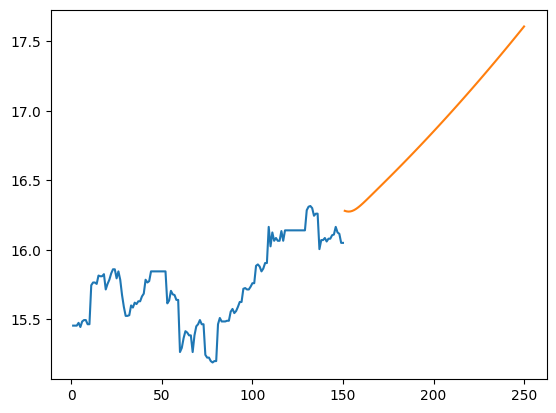

In [246]:
plt.plot(day_new,scaler.inverse_transform(close_stock[8096:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

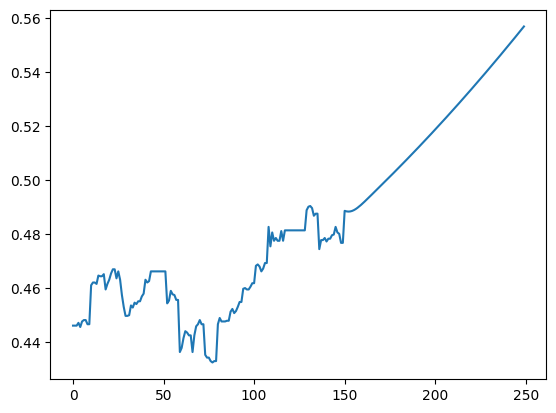

In [247]:
df=close_stock.tolist()
df.extend(lst_output)
plt.plot(df[len(close_stock)-previous_days:])
plt.show()

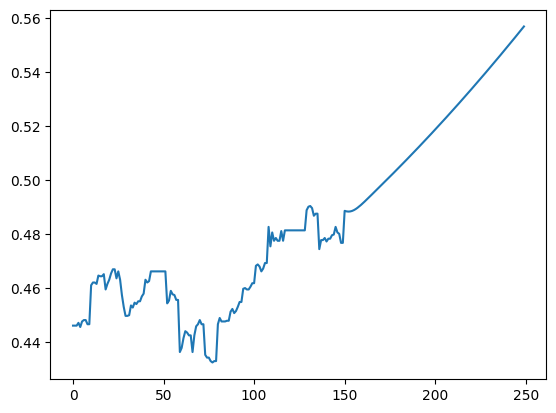

In [248]:
df2=close_stock.tolist()
df2.extend(lst_output)
plt.plot(df[8096:])#8238